In [1]:
#This program is written to explain the implementation of correlated error in Generalized Linear Model
#Date: 10th Jan 2024

#The details of its theory is explain in our manuscript (Model Design Section),
#Author: Chapagain, K.; Kittipiyakul, S.; Kulthanavit, P. 
#Title: Short-Term Electricity Demand Forecasting: Impact Analysis of Temperature for Thailand. Energies 2020, 13, 2498. 
#https://doi.org/10.3390/en13102498

In [2]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from dateutil.parser import parse
from datetime import datetime
from pandas.tseries.offsets import Week, Day, MonthEnd, WeekOfMonth, Hour, Minute
import statsmodels.api as sm
import statsmodels.formula.api as smf #For GLSAR model
import patsy
import seaborn as sns

In [3]:
#Load the .csv file (Electricity consumption data of Thailand (MCC region)
data=pd.read_csv('GLSAR_data.csv', index_col=0, parse_dates=True)
print('Rows and columns', data.shape)

Rows and columns (52608, 68)


In [4]:
data.columns

Index(['load', 'temp', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Weekday',
       'HH', 'old_temp', 'Holiday', 'HolidayType', 'HolidayLong', 'WD', 'MD',
       'Flood', 'WorkingHour', 'load_art', 'trend', 'DayAfterHoliday',
       'DayAfterLongHoliday', 'DayAfterSongkran', 'DayAfterNewyear',
       'MA2pmTemp', 'MaxTemp', 'MaxTempYesterday', 'Load2pmYesterday',
       'Holiday2', 'load1d', 'load2d', 'load3d', 'load4d', 'load5d', 'load6d',
       'load7d', 'load14d', 'load21d', 'load28d', 'load1d_cut2pm',
       'load2d_cut2pm', 'HolidayLongOld', 'DayAfterLongHolidayOld', 'Religion',
       'DayAfterLabor', 'DayAfterReligion', 'load1D_cut2pm_RR',
       'load1D_cut2pm_RR_offset', 'Load2pmYesterday_RR', 'Songkran1D',
       'Songkran2D', 'Newyear1D', 'Newyear2D', 'load1D_cut2pm_RRR', 'Asalha',
       'Chakri', 'Chulalongkorn', 'Constitution', 'Coronation', 'King',
       'Labor', 'Lent', 'Makha', 'Newyear', 'Ploughing', 'Queen', 'Songkran',
       'Visakha', 'load1D_cut2pm_RRR_offset'],

In [5]:
data.head()

,load,temp,Year,Month,Day,Hour,Minute,Weekday,HH,old_temp,...,King,Labor,Lent,Makha,Newyear,Ploughing,Queen,Songkran,Visakha,load1D_cut2pm_RRR_offset
2011-01-01 00:00:00,2950.016577,23.574702,2011,1,1,0,0,5,0,23.574702,...,0,0,0,0,1,0,0,0,0,-2
2011-01-01 00:30:00,2866.553659,23.118490,2011,1,1,0,30,5,1,23.118490,...,0,0,0,0,1,0,0,0,0,-2
2011-01-01 01:00:00,2789.087635,22.600000,2011,1,1,1,0,5,2,22.600000,...,0,0,0,0,1,0,0,0,0,-2
2011-01-01 01:30:00,2698.085541,22.020073,2011,1,1,1,30,5,3,22.020073,...,0,0,0,0,1,0,0,0,0,-2
2011-01-01 02:00:00,2627.971021,21.401553,2011,1,1,2,0,5,4,21.401553,...,0,0,0,0,1,0,0,0,0,-2


In [6]:
#We have created the function for the ploting.
def plotgroups(groups):
    fa, fb = int(np.ceil(groups.ngroups/3)), 3
    fig, axes = plt.subplots(fa,fb,figsize=(15,3*fa), sharey=True, squeeze=False)
    j = 0
    for name, group in groups:
        group.plot(ax=axes[np.floor_divide(j,fb), np.mod(j,fb)], grid=True)
        j = j + 1
    plt.tight_layout()

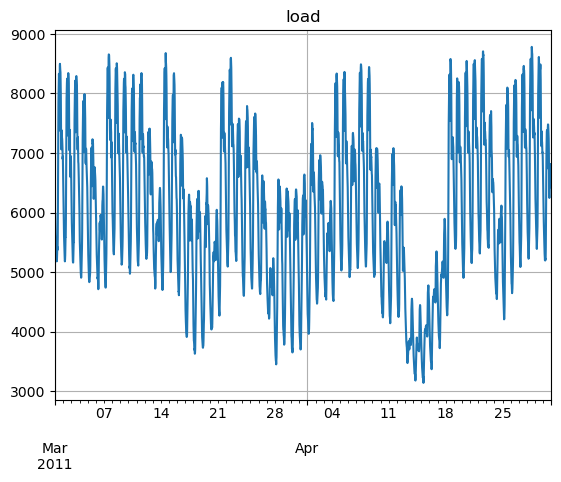

In [7]:
#Lets plot for March 2011 to April 2011
data.loc['2011-3':'2011-4','load'].plot(title='load')
plt.grid()

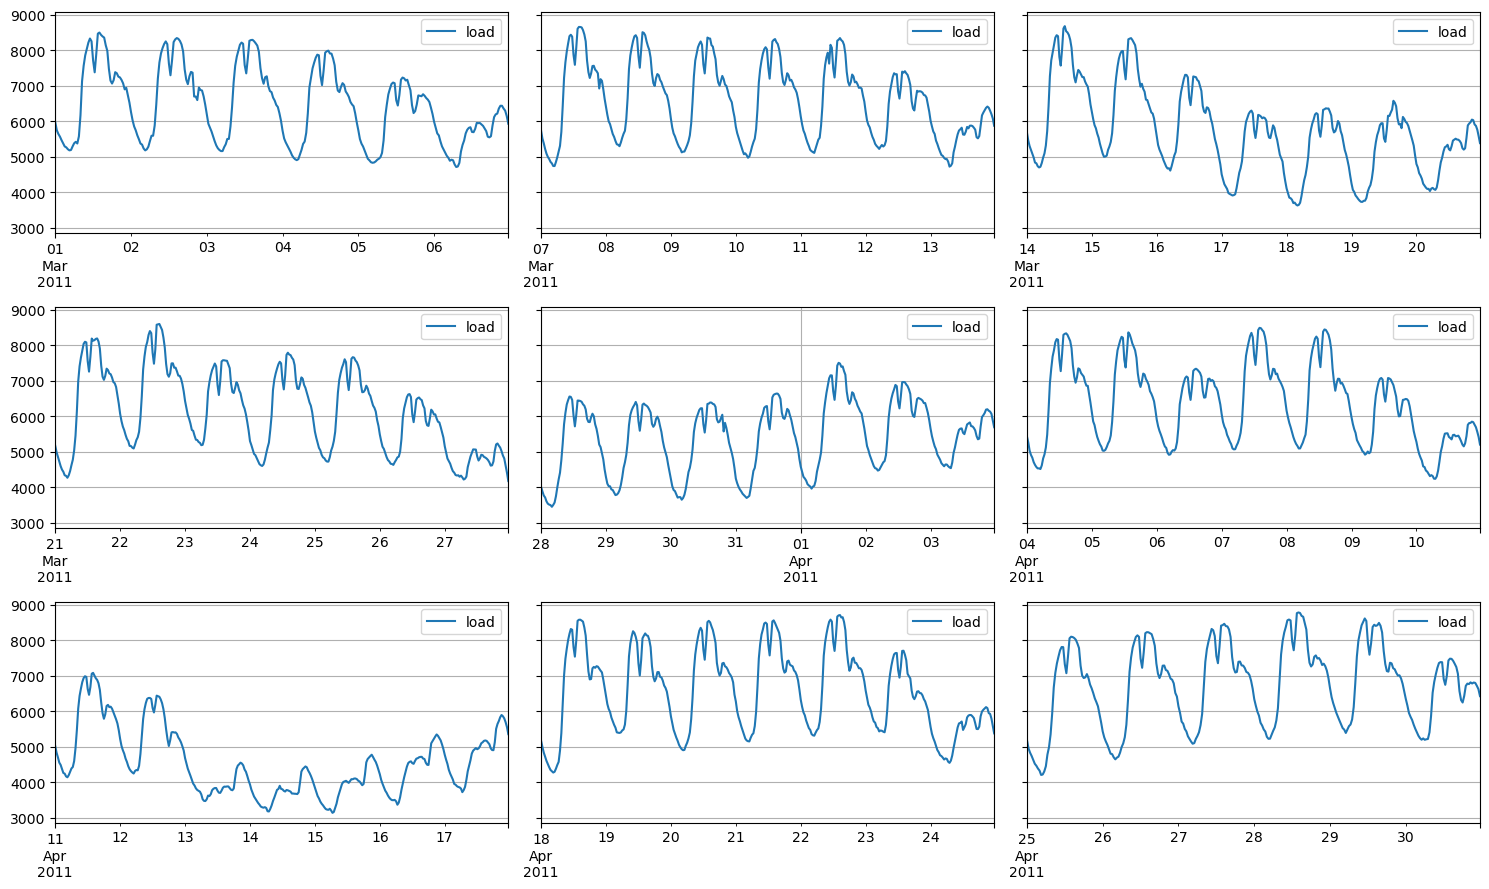

In [8]:
#We want to plot in weekly basis,
groups = data.loc['2011-3':'2011-4',['load']].resample('W')
plotgroups(groups)

In [9]:
#Before developing the model, lets separte the data,
T=48  # total half hour
train_start = '2011-01-01' #Training data starts from 2011 Jan
train_end = '2012' #Training ends in 2012 Dec
test_start = '2013' #Test starts by 2013 Jan
test_end = '2013'   #Test ends by 2013 Jan
df=data.copy()
df = df[train_start:test_end]
df.columns

Index(['load', 'temp', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Weekday',
       'HH', 'old_temp', 'Holiday', 'HolidayType', 'HolidayLong', 'WD', 'MD',
       'Flood', 'WorkingHour', 'load_art', 'trend', 'DayAfterHoliday',
       'DayAfterLongHoliday', 'DayAfterSongkran', 'DayAfterNewyear',
       'MA2pmTemp', 'MaxTemp', 'MaxTempYesterday', 'Load2pmYesterday',
       'Holiday2', 'load1d', 'load2d', 'load3d', 'load4d', 'load5d', 'load6d',
       'load7d', 'load14d', 'load21d', 'load28d', 'load1d_cut2pm',
       'load2d_cut2pm', 'HolidayLongOld', 'DayAfterLongHolidayOld', 'Religion',
       'DayAfterLabor', 'DayAfterReligion', 'load1D_cut2pm_RR',
       'load1D_cut2pm_RR_offset', 'Load2pmYesterday_RR', 'Songkran1D',
       'Songkran2D', 'Newyear1D', 'Newyear2D', 'load1D_cut2pm_RRR', 'Asalha',
       'Chakri', 'Chulalongkorn', 'Constitution', 'Coronation', 'King',
       'Labor', 'Lent', 'Makha', 'Newyear', 'Ploughing', 'Queen', 'Songkran',
       'Visakha', 'load1D_cut2pm_RRR_offset'],

In [10]:
#Based on the above variable, model is drive

##############################################################################################
model_str = 'load ~ trend + load1d_cut2pm + WD:load1d_cut2pm \
+ load7d + Load2pmYesterday + WD:Load2pmYesterday + MaxTemp + MaxTempYesterday + MA2pmTemp \
+ temp + WD:temp + MD:temp + WD:np.square(temp)\
+ WD + MD + DayAfterHoliday + DayAfterLongHoliday + DayAfterSongkran + DayAfterNewyear' 
#############################################################################################

In [11]:
#Lets prepare more details backgrounds.

OLS=False   #If OLS=True (Model is treated as OLS, otherwise Model is treated as GLSAR)
rho=7       #Nos of previous days that counts the correlated error (Only applicable if OLS is False)
printhh=True # To display half hour

train = df[train_start:train_end]
test = df[test_start:test_end]
train_size, test_size = int(train.shape[0]/T), int(test.shape[0]/T)
print('Sizes: train=%d, test=%d' % (train_size, test_size))

df['load_pred'] = 0
df['load_fitted'] = 0

model_betavalue = list()   #It stores the beta coefficients
model_rhovalue = list()    #It stores the rho coefficients (correlated error coefficients)

Sizes: train=731, test=365


In [12]:
#Code execution part

for hh in range(T): #runs for 48 half hours
    predictions = list()        #It stores prediction value for for each half hour 
    inside_betavalue=list()     #It stores beta coeffient value for for each half hour 
    inside_rhovalue=list()     #It stores correlated error coeffient value for for each half hour
    obs = list()               #It stores original data for for each half hour

    y0, X0 = patsy.dmatrices(model_str, df[df.HH==hh]) #develop the matrix with model
    y = np.asarray(y0) #Target matrix
    X = np.asarray(X0) #Training matrix
    
    for t in range(test_size): #runs for forecasting day 1 to the last (In our case 2013 Jan to 2013 Dec)
        hh_train_start = t
        hh_train_end = t + train_size 
        hh_test = hh_train_end #Prepares sliding windows
        ytrain = patsy.DesignMatrix(y[hh_train_start:hh_train_end], y0.design_info)
        Xtrain = patsy.DesignMatrix(X[hh_train_start:hh_train_end], X0.design_info)
        ytest = y[hh_test]
        Xtest = X[hh_test]
        
        if (OLS):            
            model = sm.OLS(ytrain, Xtrain)
            model_fit = model.fit(disp=0)

        else: #(GLSAR):
            model = sm.GLSAR(ytrain, Xtrain, rho) #Our GLSAR model that treats for rho=7 correlated error
            model_fit = model.iterative_fit(6) #This iterative fit can be run for MAXITR=10 normally.

        output = model_fit.predict(Xtest)
        yhat = output[0]
        predictions.append(yhat)
        obs.append(ytest)
        inside_betavalue.append(model_fit.params)
        inside_rhovalue.append(model.rho)

    print('hh=%d' % hh)
    print((model_fit.summary()))
    
    df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = predictions

    p=array(inside_betavalue)
    pp=p.mean(axis=0)
    ppp=pp.tolist()
    model_betavalue.append(ppp)

    p=array(inside_rhovalue)
    pp=p.mean(axis=0)
    ppp=pp.tolist()
    model_rhovalue.append(ppp)

hh=0
                           GLSAR Regression Results                           
Dep. Variable:                   load   R-squared:                       0.974
Model:                          GLSAR   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     373.2
Date:                Fri, 10 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:19:59   Log-Likelihood:                -4424.0
No. Observations:                 724   AIC:                             8980.
Df Residuals:                     658   BIC:                             9283.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept      

C:\Users\asus\AppData\Local\Temp\ipykernel_13000\2638859118.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3382.7198226475457, 3650.636502688304, 4310.686447654892, 5149.001528962754, 5224.635351555066, 5167.22460379465, 4728.34383593356, 5584.195723367298, 5643.729728853797, 5684.252018717613, 6026.211576485951, 5956.575558620367, 5614.351585363065, 5112.2306356328045, 5522.996533396976, 5739.598512139461, 6061.50107321802, 5737.3703282568895, 5450.2125848530395, 5110.585951773608, 4622.119437162033, 5618.663539832769, 6004.27750436902, 6087.96045397791, 6166.635404886468, 5981.746266618538, 5728.865196028255, 5216.918561662327, 5522.694848267523, 5629.971133048919, 5848.984916604026, 5773.027882140442, 5808.738399230193, 5602.025397309093, 5107.017618929471, 6137.434881665585, 6376.41466015619, 6457.092170744454, 6583.640965437948, 6429.260840931831, 6083.497875425221, 5455.6776837906145, 6145.2

hh=1
                           GLSAR Regression Results                           
Dep. Variable:                   load   R-squared:                       0.974
Model:                          GLSAR   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     375.4
Date:                Fri, 10 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:20:03   Log-Likelihood:                -4427.5
No. Observations:                 724   AIC:                             8987.
Df Residuals:                     658   BIC:                             9290.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept      

C:\Users\asus\AppData\Local\Temp\ipykernel_13000\4272522734.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_plot=df.loc['2013-01-01':'2013-12-31',['load','load_pred']].resample('M')


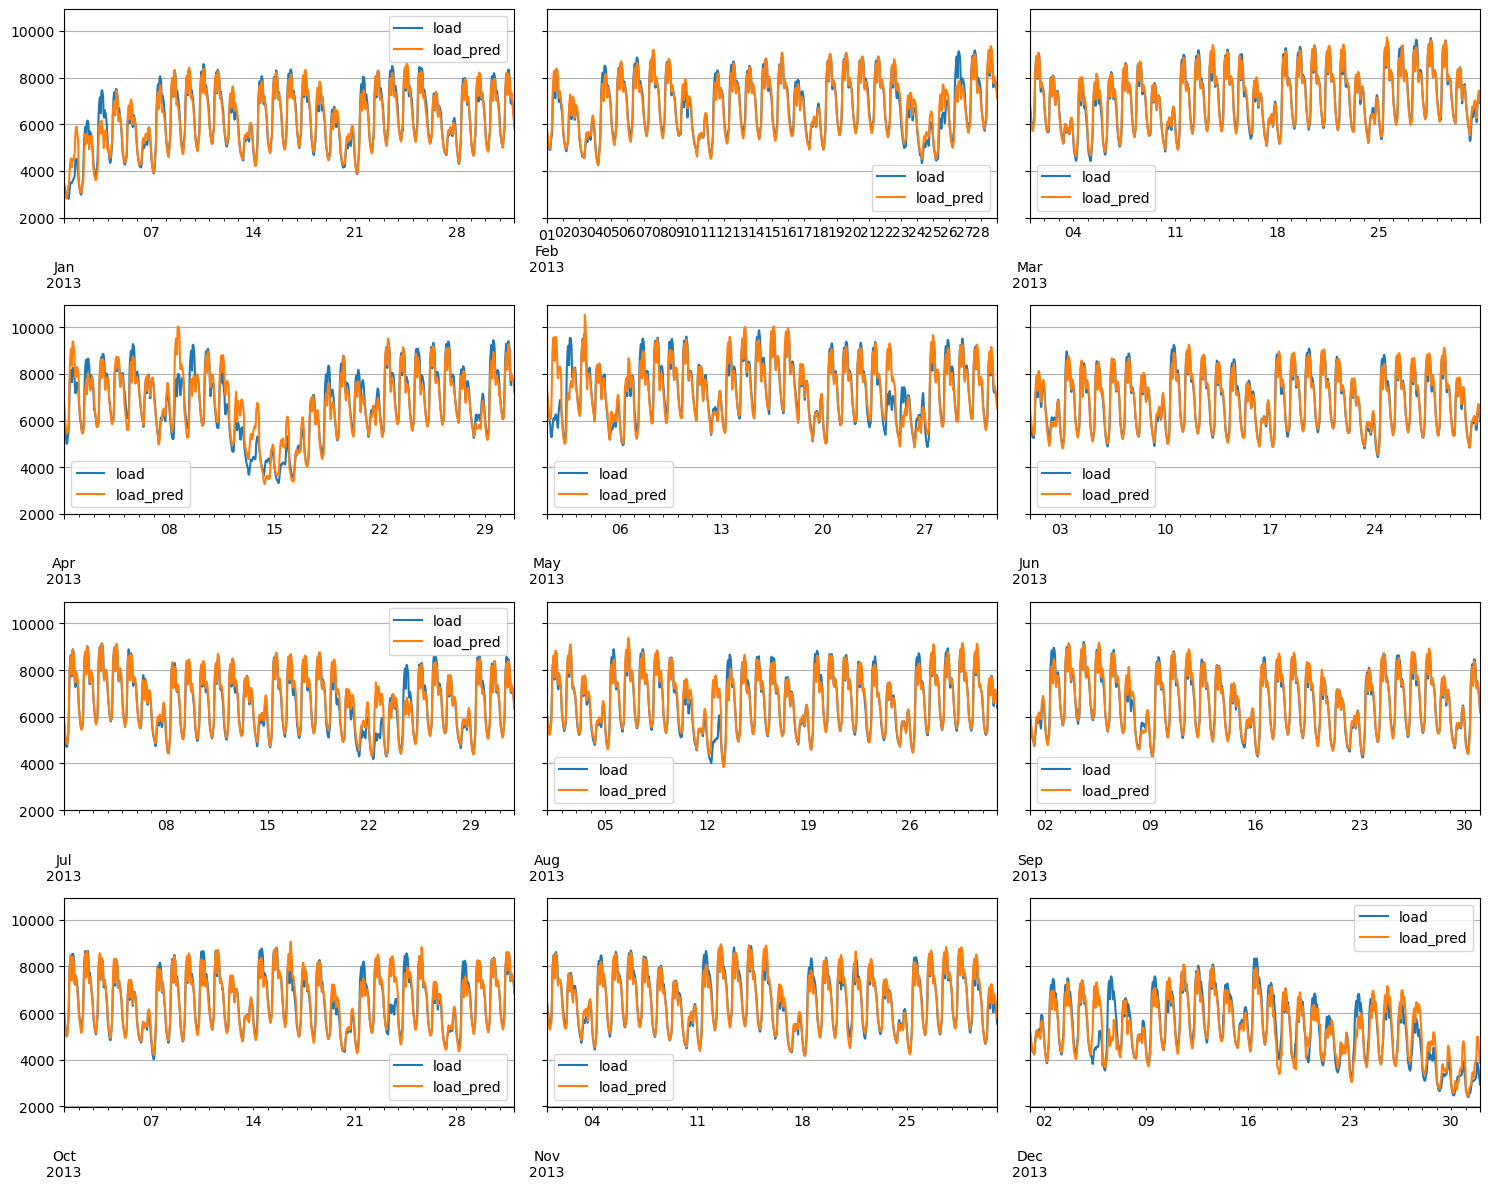

In [13]:
df.loc[(df.Year == int(test_end)) & (df.HH==hh),'load_pred'] = predictions
df_plot=df.loc['2013-01-01':'2013-12-31',['load','load_pred']].resample('M')
plotgroups(df_plot)

MAPE over all halfhours in 2013 = 3.15


<Axes: >

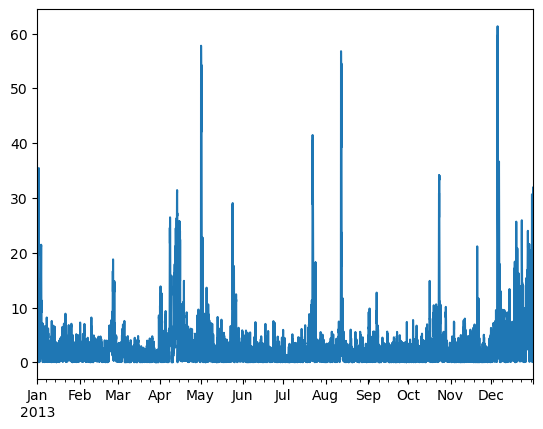

In [14]:
df['resid'] = df.loc[test_end,'load']-df.loc[test_end,'load_pred']
df['mape'] = 100 * np.abs(df.loc[test_end,'resid'])/df.loc[test_end,'load']
mape = df.loc[test_end,'mape'].mean()
print('MAPE over all halfhours in %s = %.2f' % (test_end, mape))

df.loc[test_end,'mape'].plot()      


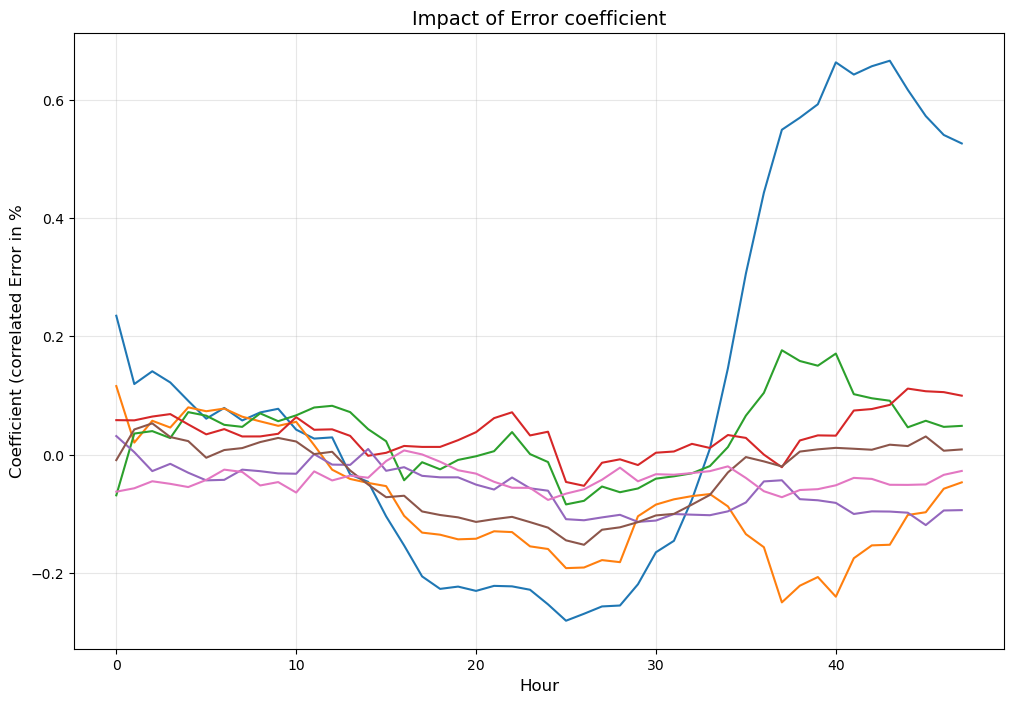

In [15]:
# Convert the given rho_vec into a DataFrame
hours = list(range(T))  # Hours from 0 to 47
rho_df = pd.DataFrame(model_rhovalue, index=hours, columns=[f'AR{i+1}' for i in range(rho)])

# Plot rho values for each variable
plt.figure(figsize=(12, 8))
for column in rho_df.columns:
    plt.plot(rho_df.index, rho_df[column], label=column)

# Configure the plot
plt.title("Impact of Error coefficient", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Coefficient (correlated Error in %", fontsize=12)
#plt.legend(title="Correlated Error")
plt.grid(alpha=0.3)
plt.show()